In [83]:
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pymc3 as pm
data_folder = "titanic" # set to the name of the folder where you keep the data
test = pd.read_csv(os.path.join(data_folder, "test.csv"))
train = pd.read_csv(os.path.join(data_folder, "train_full.csv"))

In [84]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

In [85]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [86]:
# helper functions 
def binarize_cabin(df):
    cabins = df["Cabin"].values
    df["Cabin"] = [1 if isinstance(cabin, str) else 0 for cabin in cabins]
    return df

def binarize_gender(df):
    genders = df["Sex"].values
   # print(genders)
    df["Sex"] = [0 if x == "male" else 1 for x in genders]
    return df

In [91]:
# base model. 
def preprocessing(df): 
    # subset and binarize 
    sub = df[["Survived", "Pclass", "Sex", "Age", "Fare", "Cabin"]]
    df1 = binarize_cabin(sub)
    df2 = binarize_gender(sub)
    df2["Age"] = df2["Age"].fillna(df2["Age"].median())
    
    # split into outcome and predictors. 
    X = df2[["Pclass", "Sex", "Age", "Fare", "Cabin"]]
    Y = df2["Survived"]
    
    # min-max-scaling 
    min_max_scaler = MinMaxScaler()
    X[["Pclass", "Age", "Fare"]] = min_max_scaler.fit_transform(X[["Pclass", "Age", "Fare"]])
    
    # return stuff
    return(X, Y)


In [94]:
# generate for training. 
x, y = preprocessing(train)

In [96]:
# theano tensor import. 
import theano.tensor as T

# logistic 
def logistic(l):
    return 1 / (1 + T.exp(-l))

# make the model
basic_model = pm.Model()

with basic_model:
    
    #data = pm.Data('data', x)
    
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu = 0, sigma = 10)
    beta = pm.Normal("beta", mu = 0, sigma = 10, shape = 5) # shape = 3 since we have 3 predictors. 
    
    # Expected value of outcome
    mu = alpha + beta[0] * x.Pclass.values + beta[1] * x.Sex.values + beta[2] * x.Age.values + beta[3] * x.Fare.values + beta[4] * x.Cabin.values

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=logistic(mu), observed = y.values)


In [97]:
# map estimate
map_estimate = pm.find_MAP(model = basic_model)
map_estimate

{'alpha': array(0.81141359),
 'beta': array([-1.9016614 ,  0.81141359, -2.84255968,  2.08024609,  0.        ])}

In [57]:
with basic_model:
    # draw 500 posterior samples
    trace = pm.sample(500, return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 68 seconds.
The acceptance probability does not match the target. It is 0.8821441302159205, but should be close to 0.8. Try to increase the number of tuning steps.


In [58]:
with basic_model:
    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    trace = pm.sample(5000, step=step, return_inferencedata=False)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [beta]
>Slice: [alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 75 seconds.
The number of effective samples is smaller than 10% for some parameters.


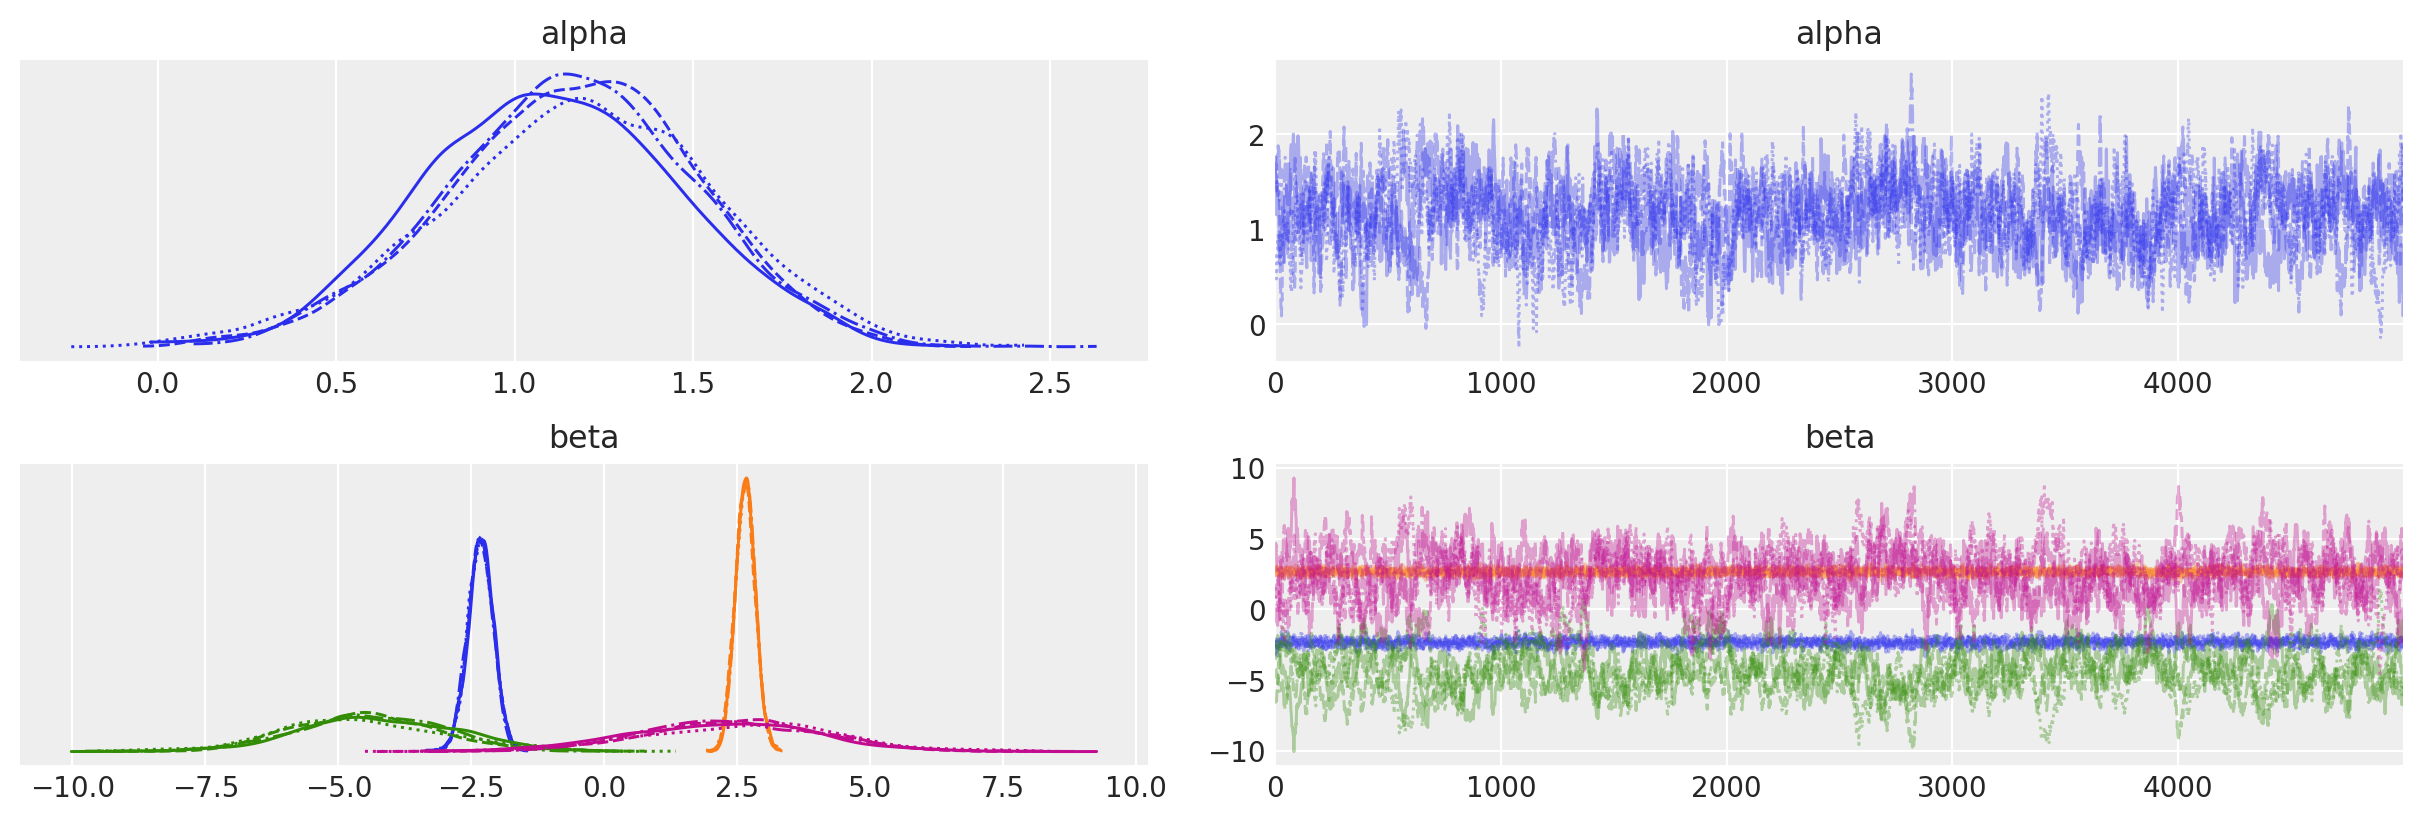

In [59]:
with basic_model:
    az.plot_trace(trace);

In [60]:
with basic_model:
    display(az.summary(trace, round_to=2))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,1.15,0.36,0.46,1.83,0.02,0.01,320.69,320.69,321.99,956.56,1.01
beta[0],-2.32,0.24,-2.79,-1.89,0.00,0.00,2363.61,2363.61,2366.67,4298.73,1.00
beta[1],2.66,0.19,2.30,3.00,0.00,0.00,7182.62,7086.90,7206.29,8638.20,1.00
beta[2],-4.40,1.49,-7.12,-1.54,0.10,0.07,225.47,225.47,225.67,525.16,1.02
beta[3],2.38,1.79,-0.99,5.72,0.11,0.08,259.70,259.70,259.76,686.10,1.02


## prediction

In [64]:
## on unseen data 
test = pd.read_csv(os.path.join(data_folder, "test.csv"))


c:\users\95\anaconda3\envs\cogmod\lib\site-packages\pymc3\sampling.py:1687: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [69]:
# sample from the model?
with basic_model:
    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.


In [70]:
test

# 

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,1
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,0


In [ ]:
# new data 
with basic_model:
    # change the value and shape of the data
    pm.set_data(
        {
            "x_obs": [-1, 0, 1.0],
            # use dummy values with the same shape:
            "y_obs": [0, 0, 0],
        }
    )

    post_pred = pm.sample_posterior_predictive(idata.posterior)
    
    
with basic_model:
    
    #data = pm.Data('data', x)
    
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu = 0, sigma = 10)
    beta = pm.Normal("beta", mu = 0, sigma = 10, shape = 4) # shape = 3 since we have 3 predictors. 
    Pclass, Sex, Age, AgeSQ = beta[0], beta[1], beta[2], beta[3]
    
    # Expected value of outcome
    mu = alpha + Pclass * x.Pclass.values + Sex * x.Sex.values + Age * x.Age.values + AgeSQ * x.Age.values**2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=logistic(mu), observed = y.values)

In [61]:
## to-do: (1) scale predictors (2) add more predictors (3) predict. 
# sklearn.preprocessing.MinMaxScaler.fit_transform(df[[column]])